In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi
from sklearn.preprocessing import MinMaxScaler
import re

# spatial
import xarray as xa
import rasterio
import pyproj
import rioxarray
import xesmf as xe

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import joblib


from sklearn.metrics import r2_score
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from statsmodels.multivariate.manova import MANOVA

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting, ml_utils

In [2]:
corr_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img"
corr_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img.hdr"
mask_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img"
mask_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img.hdr"

hs_mask_metadata = open_image(mask_fp_hdr)
hs_corrected_metadata = open_image(corr_fp_hdr)
print("masked:", hs_mask_metadata)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = open_image(corr_fp_hdr).load()

masked: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_mask_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:             1
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8
corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32


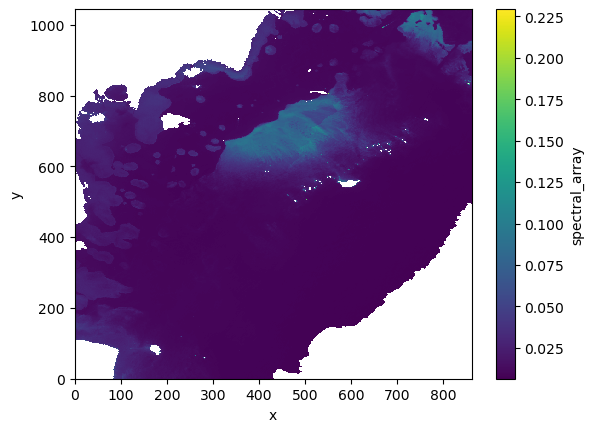

In [169]:
from pyproj import Transformer

def envi_to_xarray_with_latlon(envi_fp, band_vals: list[float]=None):
    # Open the ENVI file using rasterio
    with rasterio.open(envi_fp) as src:
        data = src.read()
        transform = src.transform
        height, width = src.shape

        # generate UTM coordinates from pixel indices using the affine transform
        x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
        x_coords, y_coords = rasterio.transform.xy(transform, y_coords, x_coords)

        # Convert the UTM coordinates to numpy arrays
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

        # Convert UTM to lat/lon using pyproj or rasterio's CRS info
        transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
        lon_coords, lat_coords = transformer.transform(x_coords, y_coords)

        # Reshape lat and lon arrays to match the image dimensions
        lat_coords = np.reshape(lat_coords, (height, width))
        lon_coords = np.reshape(lon_coords, (height, width))

        # Create the xarray Dataset with lat/lon as coordinates
        dataset = xa.DataArray(
            data=data,  # The raster data
            dims=("band", "y", "x"),  # Dimensions of the data (e.g., bands, rows, cols)
            coords={
                "lat": (["y", "x"], lat_coords),  # Latitude coordinates (reshaped)
                "lon": (["y", "x"], lon_coords),  # Longitude coordinates (reshaped)
                "band": band_vals if band_vals else np.arange(1, data.shape[0] + 1),  # Band indices
            },
            attrs=src.meta  # Include the ENVI metadata
        )
        
    return dataset

spatial_xy_xa = envi_to_xarray_with_latlon(corr_fp)
mask_xa = envi_to_xarray_with_latlon(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(spatial_xy_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
masked_scene_xa = spatial_xy_xa.where(mask_xa == 1, np.nan)
masked_scene_xa.name = "spectral_array"
# assign band values actual wavelength values
masked_scene_xa.coords["band"] = hs_corrected_metadata.bands.centers

# visualise data
mean_scene_xa = masked_scene_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

In [86]:
# matching spectra
validation_spectra_fp = file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv"
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
validation_spectra = pd.read_csv(validation_spectra_fp)
validation_spectra.columns = validation_spectra.columns.astype(float)
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index
# select kbay spectra
kbay_validation_spectra = validation_spectra.iloc[kbay_indices]
kbay_validation_spectra.head()

350.718103   353.548360   356.378673   359.209042   362.039467   \
1151      -0.0936      -0.0753       0.0055       0.0092       0.0261   
1152      -0.1003      -0.0732       0.0104       0.0123       0.0251   
1153      -0.0942      -0.0749       0.0012       0.0124       0.0233   
1154      -0.0933      -0.0721       0.0007       0.0100       0.0232   
1155      -0.1004      -0.0798      -0.0035       0.0052       0.0208   

      364.869949   367.700487   370.531081   373.361731   376.192438   ...  \
1151       0.0194       0.0168       0.0170       0.0169       0.0213  ...   
1152       0.0189       0.0178       0.0199       0.0180       0.0227  ...   
1153       0.0247       0.0194       0.0187       0.0168       0.0208  ...   
1154       0.0218       0.0167       0.0204       0.0158       0.0201  ...   
1155       0.0164       0.0109       0.0154       0.0125       0.0159  ...   

      1020.218215  1023.061744  1025.905330  1028.748971  1031.592670  \
1151       0.0076       0.0070       0.0067       0.0071       0.0076   
1152       0.0073       0.0077       0.0072       0.0069       0.0069   
1153       0.0071       0.0069       0.0071       0.0072       0.0072   
1154       0.0068       0.0066       0.0064       0.0065       0.0064   
1155       0.0073       0.0069       0.0070       0.0075       0.0076   

      1034.436424  1037.280234  1040.124101  1042.968024  1045.812003  
1151       0.0061       0.0072       0.0068       0.0070       0.0072  
1152       0.0075       0.0073       0.0078       0.0077       0.0073  
1153       0.0072       0.0067       0.0068       0.0069       0.0068  
1154       0.0069       0.0070       0.0071       0.0060       0.0063  
1155       0.0078       0.0078       0.0078       0.0084       0.0075  

[5 rows x 246 columns]

In [154]:
kbay_spectra = ml_utils.spectral_xa_to_processed_spectral_df(masked_scene_xa, sensor_range = [kbay_validation_spectra.columns.min(), kbay_validation_spectra.columns.max()+10]) # discrepancy in wavelength values much!!
kbay_spectra_no_nans = kbay_spectra.dropna(inplace=False)
kbay_spectra_no_nans.head()

350.718109   353.548370   356.378662   359.209045   362.039459   \
84    -0.226065    -0.173343     0.029054     0.026362     0.048827   
85    -0.185080    -0.145685     0.031734     0.042032     0.056400   
86    -0.185541    -0.129247     0.039026     0.036056     0.053762   
87    -0.177682    -0.122697     0.040667     0.046347     0.061807   
88    -0.177682    -0.122697     0.040667     0.046347     0.061807   

    364.869934   367.700500   370.531067   373.361725   376.192444   ...  \
84     0.039588     0.029481     0.023329     0.017586     0.022286  ...   
85     0.049959     0.036195     0.036955     0.023494     0.027282  ...   
86     0.046651     0.035294     0.030869     0.022162     0.028531  ...   
87     0.045808     0.036235     0.036893     0.023296     0.029488  ...   
88     0.045808     0.036235     0.036893     0.023296     0.029488  ...   

    1020.218201  1023.061768  1025.905273  1028.749023  1031.592651  \
84     0.003392     0.002484     0.004786     0.006878     0.006311   
85    -0.004237    -0.004126    -0.003085    -0.002034     0.000286   
86    -0.000491     0.001376     0.001426     0.003975     0.003139   
87     0.000901     0.001693     0.002987     0.003684     0.004522   
88     0.000901     0.001693     0.002987     0.003684     0.004522   

    1034.436401  1037.280273  1040.124146  1042.968018  1045.812012  
84     0.009455     0.009783     0.012087     0.013919     0.016255  
85     0.002187     0.001824     0.002732     0.004041     0.006909  
86     0.004987     0.006605     0.008619     0.009294     0.010524  
87     0.004675     0.006394     0.006645     0.008309     0.011872  
88     0.004675     0.006394     0.006645     0.008309     0.011872  

[5 rows x 246 columns]

In [155]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Build KDTree for kbay_spectra (the dataset to be searched for the closest spectra)
tree = KDTree(kbay_spectra_no_nans.values)

# Query the KDTree to find the nearest neighbor in kbay_spectra for each spectrum in kbay_validation_spectra
# This returns both the distance and the index of the closest point in kbay_spectra
distances, indices = tree.query(kbay_validation_spectra.values, k=1)  # k=1 finds the single closest match

In [208]:
site_df = pd.DataFrame(kbay_spectra.index.isin(indices).astype(float), columns=["site"])

site_array = xa.DataArray(
    data=site_df.values.reshape(masked_scene_xa.shape[1], masked_scene_xa.shape[2]), 
    coords={"lat": masked_scene_xa.coords["lat"], "lon": masked_scene_xa.coords["lon"]}, 
    dims=("y", "x"), 
    name="site"
)

# merge with masked_scene_xa
scene_site_xa = xa.merge([site_array, masked_scene_xa])
scene_site_xa.rio.write_crs(masked_scene_xa.rio.crs, inplace=True)

scene_site_xa = scene_site_xa.assign_coords(
    x=np.arange(scene_site_xa.sizes['x']),
    y=np.arange(scene_site_xa.sizes['y'])
)

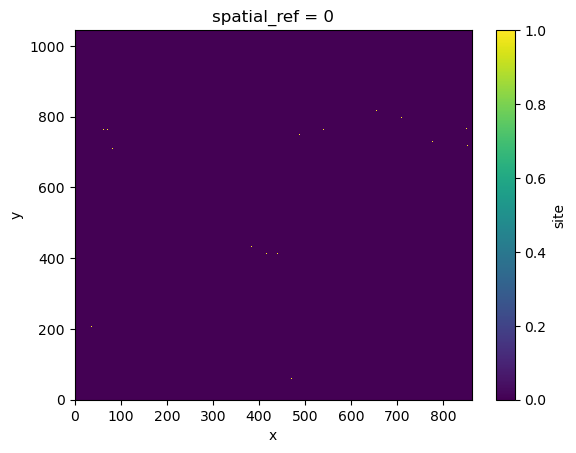

In [201]:
scene_site_xa.site.plot.imshow();
# plot as scatter the validation locations (from X and Y columns)

In [132]:
print("retrieved spectra:", len(indices))
print("og spectra:", len(kbay_validation_spectra))

retrieved spectra: 421
og spectra: 421


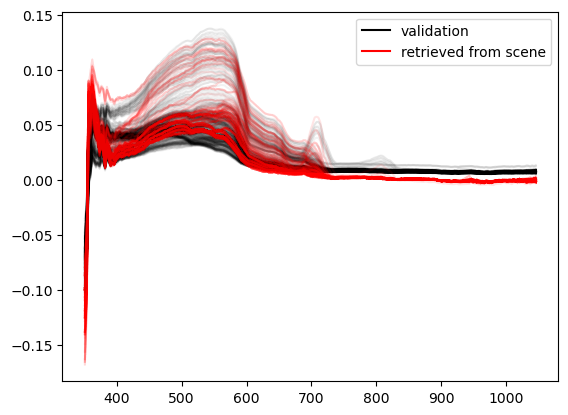

In [150]:
# plot the retrieved spectra and the validation spectra
plt.plot(kbay_validation_spectra.T, c="k", alpha=0.05);
# retrieved spectra 
retrieved_spectra = kbay_spectra.iloc[indices]
plt.plot(retrieved_spectra.T, c="r", alpha=0.05);

plt.plot([], c="k", label="validation")
plt.plot([], c="r", label="retrieved from scene")
plt.legend();

In [253]:

def regrid_with_xesmf(ds: xa.Dataset | xa.DataArray) -> xa.Dataset:
    # Reproject the dataset first, keeping the original shape and filling nodata with NaN
    ds = ds.rio.reproject("EPSG:4326", shape=(ds.sizes["y"], ds.sizes["x"]), nodata=np.nan)
    
    # Create new latitude and longitude arrays for the target grid
    lat_new = np.linspace(ds.lat.min(), ds.lat.max(), ds.sizes['y'])
    lon_new = np.linspace(ds.lon.min(), ds.lon.max(), ds.sizes['x'])

    # Define the target grid with the new latitude and longitude coordinates
    target_grid = xa.Dataset({
        'lat': (['lat'], lat_new),
        'lon': (['lon'], lon_new)
    })

    # Create the regridder object (bilinear interpolation)
    regridder = xe.Regridder(ds, target_grid, 'bilinear', unmapped_to_nan=True)

    if isinstance(ds, xa.Dataset):
        regridded_data = xa.Dataset()
        for var in ds.data_vars:
            # Only regrid variables that have dimensions compatible with lat/lon
            if 'y' in ds[var].dims and 'x' in ds[var].dims:
                regridded_data[var] = regridder(ds[var])
                regridded_data[var].attrs = ds[var].attrs
            else:
                # Skip variables without spatial dimensions or handle them differently
                regridded_data[var] = ds[var]
    else:
        # If ds is a DataArray, directly regrid it
        regridded_data = regridder(ds)
        regridded_data.attrs = ds.attrs

    # Ensure the new dataset has the correct CRS after regridding
    regridded_data.rio.write_crs("EPSG:4326", inplace=True)
    
    return regridded_data
# test_scene_xa = regrid_with_xesmf(masked_scene_xa)
test_scene_xa = regrid_with_xesmf(scene_site_xa)


In [256]:
np.nansum(test_scene_xa.spectral_array.values)

0.0

In [213]:
# scene_xa.mean(dim="band", skipna=True).plot.imshow()
np.nansum(scene_xa.site.values)

78.15239537064969

In [228]:
np.nansum(scene_xa.spectral_array)

0.0

In [226]:
masked_scene_vals = scene_xa.spectral_array.values.reshape(scene_xa.sizes["band"], -1)

wvs = hs_corrected_metadata.bands.centers
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)

np.nansum(masked_scene_vals)

0.0

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


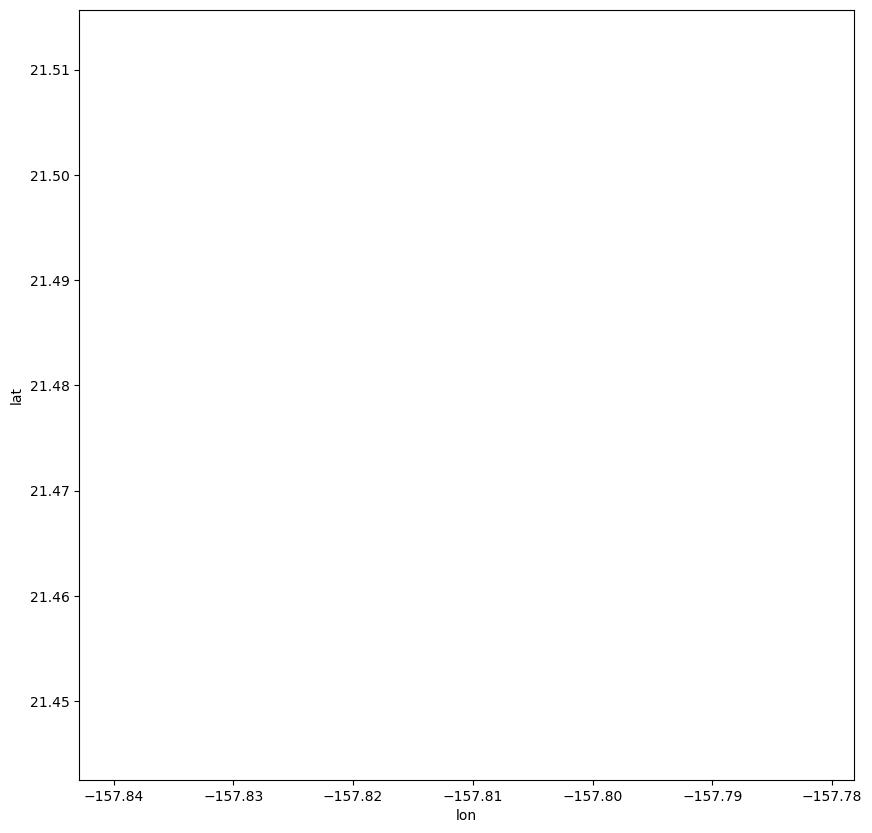

In [224]:
# plot, taking band values as RGB values
vis_percentiles=(0.1, 99.9)
rgb_vals = plotting.generate_spectra_color(hs_vals, vis_percentiles=vis_percentiles)

# reform rgb_vals back to masked_scene_xa dataset
rgb_xa = xa.DataArray(rgb_vals.reshape(len(scene_xa.lat), len(scene_xa.lon), -1), dims=("lat", "lon", "rgb"), coords={"lat": scene_xa.lat, "lon": scene_xa.lon, "rgb": ["r", "g", "b"]})
rgb_xa.plot.imshow(rgb="rgb", figsize=(10, 10), robust=True);

# ML

In [9]:
# load model

model_fp = file_ops.RESOURCES_DIR_FP / "models" / "20241001-151758" / "best_rf.pkl"
rf_model = joblib.load(model_fp)

# remove nans
no_nan_hs_vals = hs_vals.dropna()
no_nan_hs_vals


452.642761  455.475067  458.307404  461.139801  463.972229  \
1631      0.033974    0.034218    0.034101    0.034888    0.035233   
1632      0.033936    0.034379    0.034190    0.035044    0.035332   
1633      0.034138    0.034544    0.034799    0.035129    0.035569   
1634      0.034222    0.034609    0.035009    0.035271    0.035426   
1635      0.034338    0.034610    0.034735    0.035316    0.035509   
...            ...         ...         ...         ...         ...   
899384    0.051269    0.052503    0.053018    0.054111    0.055018   
899385    0.051452    0.052470    0.052797    0.054289    0.055162   
899386    0.052550    0.053595    0.054386    0.055707    0.056266   
899387    0.053167    0.053970    0.055334    0.056296    0.056802   
899388    0.053875    0.054645    0.055653    0.056616    0.057396   

        466.804749  469.637299  472.469940  475.302612  478.135345  ...  \
1631      0.035303    0.035433    0.035862    0.036112    0.036608  ...   
1632      0.035455    0.035430    0.035601    0.036188    0.036625  ...   
1633      0.035654    0.035749    0.035982    0.036190    0.036938  ...   
1634      0.035838    0.035969    0.036149    0.036489    0.037001  ...   
1635      0.035713    0.035830    0.036356    0.036463    0.037028  ...   
...            ...         ...         ...         ...         ...  ...   
899384    0.055418    0.056156    0.057172    0.057811    0.058486  ...   
899385    0.055634    0.056112    0.056887    0.057851    0.058519  ...   
899386    0.057018    0.057833    0.058566    0.059426    0.060251  ...   
899387    0.057754    0.058715    0.059617    0.060273    0.061185  ...   
899388    0.058242    0.058931    0.060280    0.060859    0.061699  ...   

        662.383484  665.219910  668.056458  670.893005  673.729614  \
1631      0.004206    0.004262    0.004097    0.003846    0.003831   
1632      0.004337    0.004383    0.004109    0.003848    0.003875   
1633      0.004839    0.004686    0.004582    0.004226    0.004257   
1634      0.004821    0.004652    0.004662    0.004271    0.004383   
1635      0.004745    0.004668    0.004543    0.004241    0.004372   
...            ...         ...         ...         ...         ...   
899384    0.022247    0.020915    0.019856    0.019221    0.018742   
899385    0.021961    0.020521    0.019470    0.019003    0.018339   
899386    0.022878    0.021715    0.020527    0.019976    0.019481   
899387    0.023249    0.022167    0.021127    0.020542    0.019932   
899388    0.022572    0.021484    0.020574    0.020136    0.019339   

        676.566284  679.403015  682.239807  685.076599  687.913513  
1631      0.003679    0.003672    0.003651    0.003740    0.004191  
1632      0.003724    0.003844    0.003747    0.003798    0.004221  
1633      0.004207    0.004326    0.004066    0.004143    0.004926  
1634      0.004318    0.004263    0.004351    0.004185    0.005031  
1635      0.004191    0.004222    0.004379    0.004216    0.004873  
...            ...         ...         ...         ...         ...  
899384    0.018600    0.018430    0.018052    0.018235    0.018637  
899385    0.018204    0.018107    0.017604    0.017863    0.018226  
899386    0.019130    0.019043    0.018819    0.018932    0.019255  
899387    0.019422    0.019403    0.019296    0.019362    0.019995  
899388    0.019037    0.018814    0.018639    0.018598    0.019254  

[686658 rows x 84 columns]

In [10]:

    
endmember_rf_inferred = infer_on_spatial(rf_model, scene_xa, ["algae", "coral", "sand"])
endmember_rf_inferred

<xarray.Dataset> Size: 909MB
Dimensions:      (band: 246, lat: 1045, lon: 863)
Coordinates:
  * band         (band) float64 2kB 350.7 353.5 356.4 ... 1.043e+03 1.046e+03
  * lat          (lat) float64 8kB 21.44 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon          (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8 -157.8
    spatial_ref  int64 8B 0
Data variables:
    spectra      (band, lat, lon) float32 887MB nan nan nan nan ... nan nan nan
    algae_pred   (lat, lon) float64 7MB nan nan nan nan nan ... nan nan nan nan
    coral_pred   (lat, lon) float64 7MB nan nan nan nan nan ... nan nan nan nan
    sand_pred    (lat, lon) float64 7MB nan nan nan nan nan ... nan nan nan nan

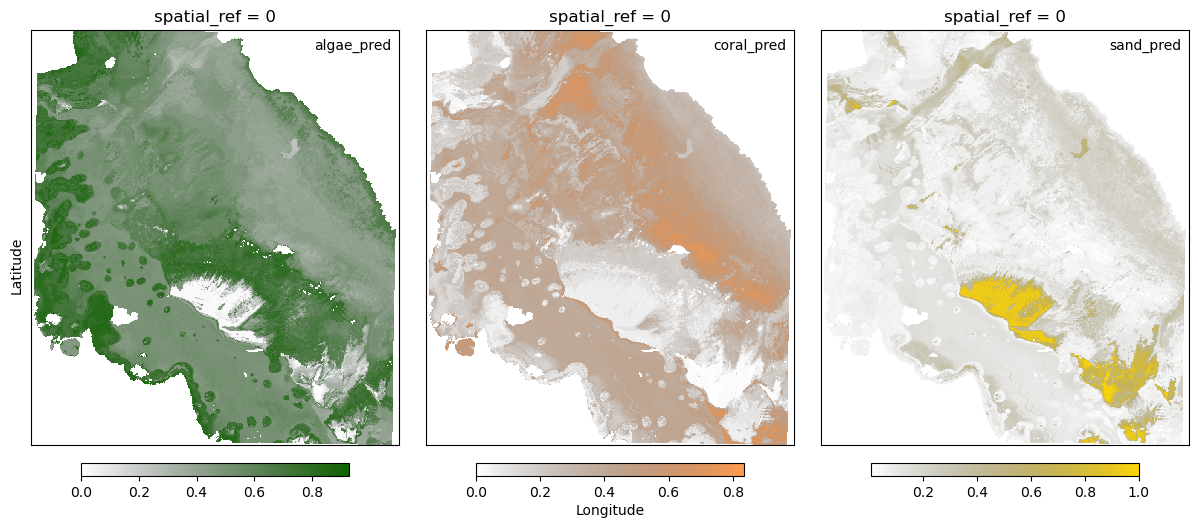

In [11]:
# cmap = sns.color_palette("rocket", as_cmap=True)
# create cmap for coral: from transparent to coral colour
from matplotlib.colors import LinearSegmentedColormap
coral_hex = "#ff9b4f"
algae_hex = "#0f6300"
sand_hex = "#ffd608"

coral_cmap = LinearSegmentedColormap.from_list("coral", ["#00000000", coral_hex])
algae_cmap = LinearSegmentedColormap.from_list("algae", ["#00000000", algae_hex])
sand_cmap = LinearSegmentedColormap.from_list("sand", ["#00000000", sand_hex])

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

pred_vars = [var for var in endmember_rf_inferred.data_vars if re.search(r'_pred$', var)]
min_values = [np.nanmin(endmember_rf_inferred[var].values) for var in pred_vars]
max_values = [np.nanmax(endmember_rf_inferred[var].values) for var in pred_vars]

for i, (var_cmap, var) in enumerate(zip([algae_cmap, coral_cmap, sand_cmap], ["algae_pred", "coral_pred", "sand_pred"])):
    im = endmember_rf_inferred[var].plot.imshow(ax=ax[i], cmap=var_cmap, add_colorbar=False, 
                                                # vmin=min(min_values), vmax=max(max_values)
                                                )
    ax[i].text(
        0.98, 0.98, var, transform=ax[i].transAxes, ha='right', va='top',
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([])
    ax[i].set_aspect('equal')
    fig.colorbar(im, ax=ax[i], orientation='horizontal', fraction=0.03, pad=0.04)

fig.text(0.5, 0.0, 'Longitude', ha='center')
fig.text(0, 0.5, 'Latitude', va='center', rotation='vertical')

fig.tight_layout()

In [12]:
# mask depth
depth_trained_model = joblib.load(file_ops.MODELS_DIR_FP / "20241003-172159/best_rf_depth_100.pkl")
depth_rf_inferred = infer_on_spatial(depth_trained_model, scene_xa, ["depth"])

# scale depth values according to validation data
depth_rf_inferred["depth_pred"] = depth_rf_inferred["depth_pred"] * np.max(validation_data.Depth)
depth_rf_inferred

<xarray.Dataset> Size: 895MB
Dimensions:      (band: 246, lat: 1045, lon: 863)
Coordinates:
  * band         (band) float64 2kB 350.7 353.5 356.4 ... 1.043e+03 1.046e+03
  * lat          (lat) float64 8kB 21.44 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon          (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8 -157.8
    spatial_ref  int64 8B 0
Data variables:
    spectra      (band, lat, lon) float32 887MB nan nan nan nan ... nan nan nan
    depth_pred   (lat, lon) float64 7MB nan nan nan nan nan ... nan nan nan nan

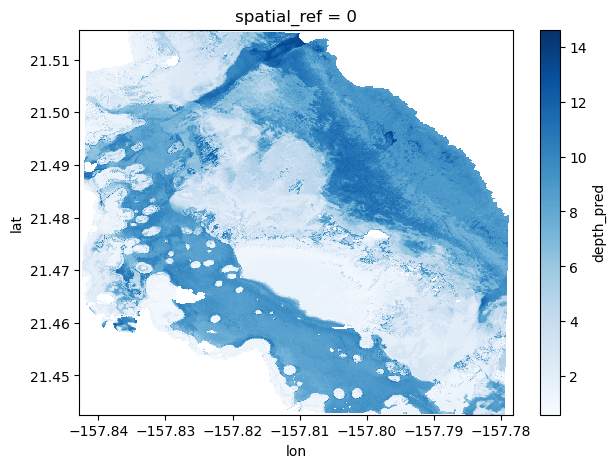

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
depth_rf_inferred["depth_pred"].plot.imshow(ax=ax, add_colorbar=True, cmap="Blues"
                                                # vmin=min(min_values), vmax=max(max_values)
                                                )

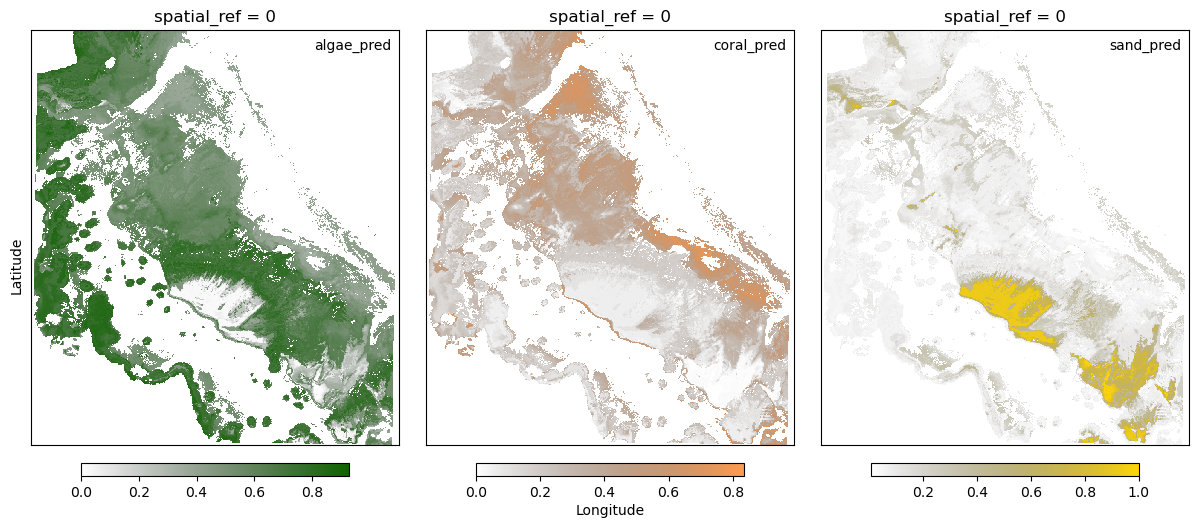

In [14]:
# depth-mask benthic classifications
masked_endmember_rf_inferred = endmember_rf_inferred.where(depth_rf_inferred["depth_pred"] <= 8, np.nan)

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

pred_vars = [var for var in masked_endmember_rf_inferred.data_vars if re.search(r'_pred$', var)]
min_values = [np.nanmin(masked_endmember_rf_inferred[var].values) for var in pred_vars]
max_values = [np.nanmax(masked_endmember_rf_inferred[var].values) for var in pred_vars]

for i, (var_cmap, var) in enumerate(zip([algae_cmap, coral_cmap, sand_cmap], ["algae_pred", "coral_pred", "sand_pred"])):
    im = masked_endmember_rf_inferred[var].plot.imshow(ax=ax[i], cmap=var_cmap, add_colorbar=False, 
                                                # vmin=min(min_values), vmax=max(max_values)
                                                )
    ax[i].text(
        0.98, 0.98, var, transform=ax[i].transAxes, ha='right', va='top',
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_yticklabels([])
    ax[i].set_aspect('equal')
    fig.colorbar(im, ax=ax[i], orientation='horizontal', fraction=0.03, pad=0.04)

fig.text(0.5, 0.0, 'Longitude', ha='center')
fig.text(0, 0.5, 'Latitude', va='center', rotation='vertical')

fig.tight_layout()

## Comparison with validation

In [15]:
print("validation sites:", validation_data.Locale.unique())
(X_train, X_test), (y1,y2), depth_labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits").generate_data()
depth_labels = depth_labels[~depth_labels.index.duplicated(keep='first')]
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index

validation sites: ['Lizard Island' 'Heron Island' 'Lanai' 'Maui' 'Hawaii' 'Kaneohe Bay'
 'Palau']


In [16]:
print("validation sites:", validation_data.Locale.unique())
(X_train, X_test), (y1,y2), benthic_labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()
benthic_labels = benthic_labels[~benthic_labels.index.duplicated(keep='first')]
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index

validation sites: ['Lizard Island' 'Heron Island' 'Lanai' 'Maui' 'Hawaii' 'Kaneohe Bay'
 'Palau']


In [17]:
# get indices of validation data in Kaneohe Bay
kbay_validation = validation_data.loc[kbay_indices]
# join labels to validation data
kbay_labels = depth_labels.loc[kbay_indices.intersection(depth_labels.index)]
kbay_benthic_labels = benthic_labels.loc[kbay_indices.intersection(benthic_labels.index)]
# kbay_validation = kbay_validation.join(kbay_labels)

extent = (kbay_validation.X >= rgb_xa.lon.values.min()) & (kbay_validation.X <= rgb_xa.lon.values.max()) & (kbay_validation.Y >= rgb_xa.lat.values.min()) & (kbay_validation.Y <= rgb_xa.lat.values.max())
kbay_validation.loc[extent]

X          Y Campaign       Locale  Station        TimeUTC  \
1151 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1152 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1153 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1154 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1155 -157.828916  21.492282   Hawaii  Kaneohe Bay      618  2/16/17 22:04   
...          ...        ...      ...          ...      ...            ...   
1559 -157.815017  21.508195   Hawaii  Kaneohe Bay      619  2/16/17 23:44   
1560 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1561 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1562 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1563 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   

          TimeLocal  Depth Metabolism Optics  ... othInvert  othOther  \
1151   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1152   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1153   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1154   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1155  2/16/17 11:04    4.9        NaN    NaN  ...         0         0   
...             ...    ...        ...    ...  ...       ...       ...   
1559  2/16/17 12:44    4.3        NaN    NaN  ...         0         0   
1560  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1561  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1562  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1563  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   

      othSponge  othUrchin  sedLimest  sedMud  sedRubble  sedSand  ROInumber  \
1151          0          0          0       0          0        4        199   
1152          0          0          0       0          0        4        199   
1153          0          0          0       0          0        4        199   
1154          0          0          0       0          0        4        199   
1155          0          0          0       0          0        9        200   
...         ...        ...        ...     ...        ...      ...        ...   
1559          0          0          0       0          0        3        287   
1560          0          0          0       0          0        2        288   
1561          0          0          0       0          0        2        288   
1562          0          0          0       0          0        2        288   
1563          0          0          0       0          0        2        288   

                            Flightline  
1151  prm20170306t194614_corr_v1w3_img  
1152  prm20170306t194614_corr_v1w3_img  
1153  prm20170306t194614_corr_v1w3_img  
1154  prm20170306t194614_corr_v1w3_img  
1155  prm20170306t194614_corr_v1w3_img  
...                                ...  
1559  prm20170306t202626_corr_v1w3_img  
1560  prm20170306t202626_corr_v1w3_img  
1561  prm20170306t202626_corr_v1w3_img  
1562  prm20170306t202626_corr_v1w3_img  
1563  prm20170306t202626_corr_v1w3_img  

[395 rows x 34 columns]

In [18]:
kbay_X_train = X_train.loc[X_train.index.intersection(kbay_indices)].loc[extent]
kbay_X_train=kbay_X_train[~kbay_X_train.index.duplicated(keep='first')]
kbay_train_inds=kbay_X_train.index
kbay_X_test = X_test.loc[X_test.index.intersection(kbay_indices)].loc[extent]
kbay_X_test=kbay_X_test[~kbay_X_test.index.duplicated(keep='first')]
kbay_test_inds=kbay_X_test.index

In [19]:
kbay_train_meta = kbay_validation.loc[kbay_train_inds]
kbay_test_meta = kbay_validation.loc[kbay_test_inds]

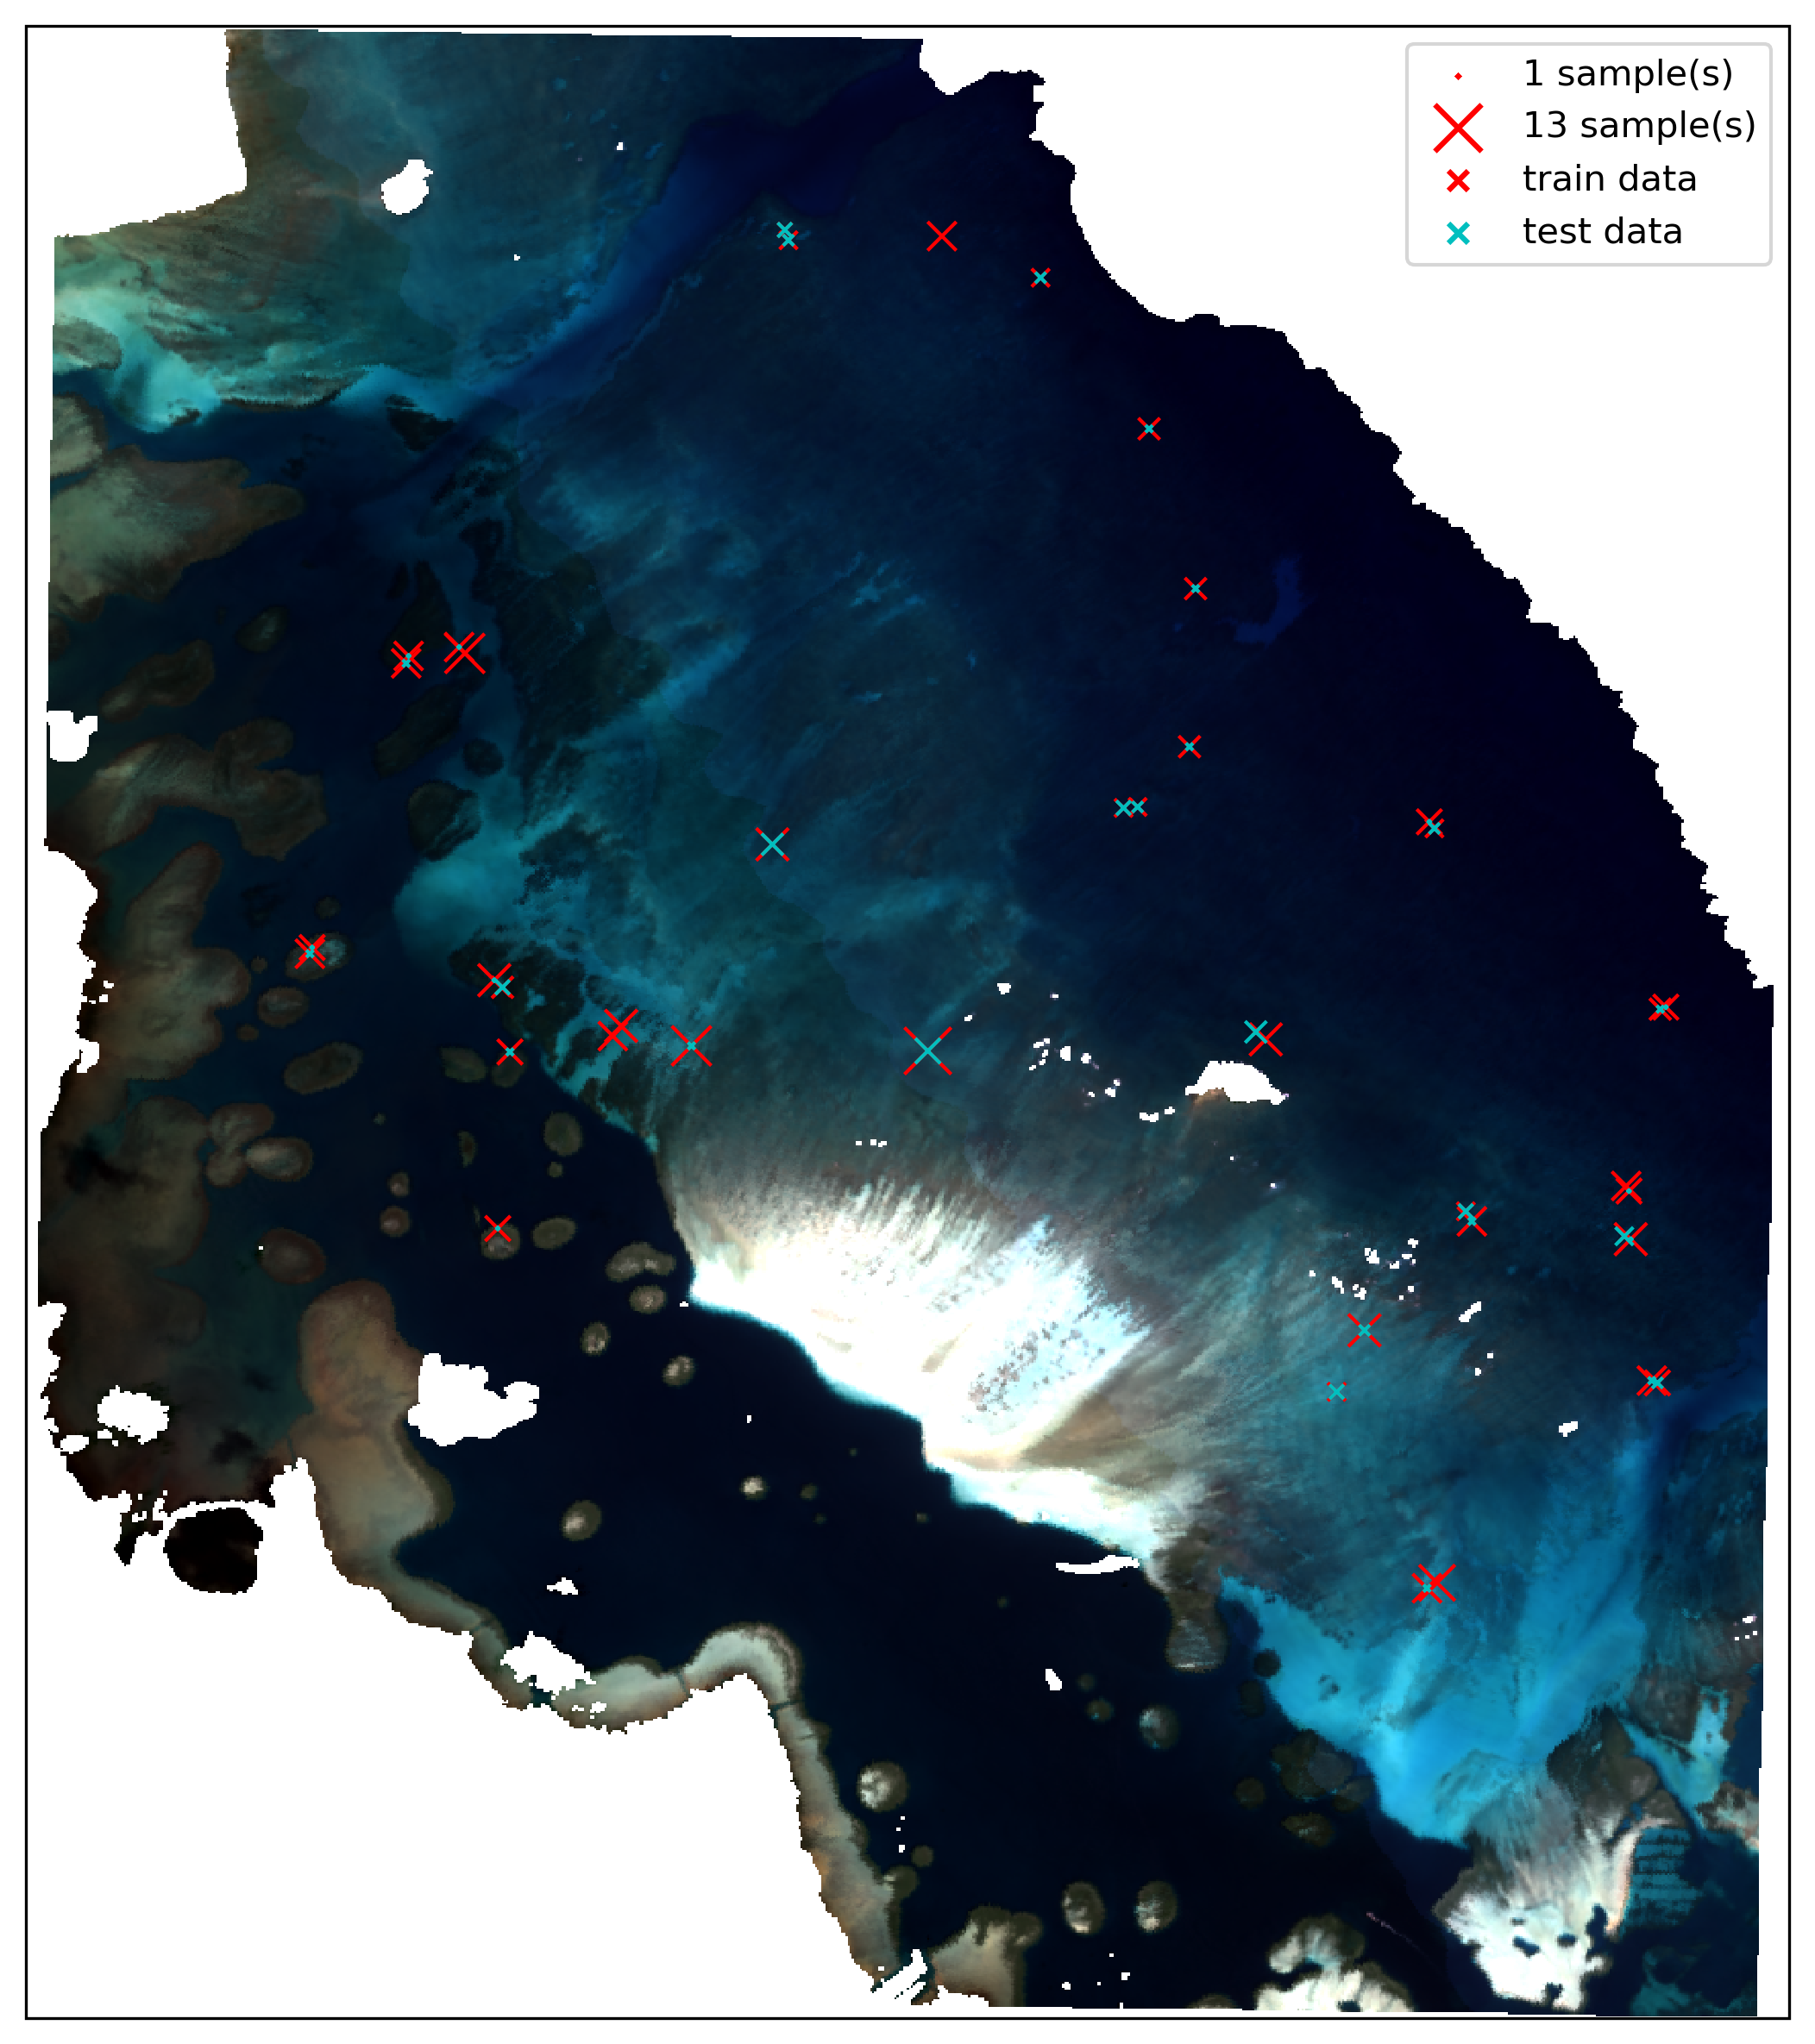

In [20]:
# join labels with validation data
kbay_validation_data = validation_data.loc[kbay_indices].join(kbay_benthic_labels, rsuffix="_label")
kbay_validation_data = kbay_validation_data.loc[kbay_indices].join(kbay_labels, rsuffix="_label")
# kbay_validation_data = validation_data.iloc[kbay_indices]
# select validation data within limits of rgb_xa
kbay_validation_data = kbay_validation_data[(kbay_validation_data.X >= rgb_xa.lon.values.min()) & (kbay_validation_data.X <= rgb_xa.lon.values.max()) & (kbay_validation_data.Y >= rgb_xa.lat.values.min()) & (kbay_validation_data.Y <= rgb_xa.lat.values.max())]

# count the number of samples at each site
train_sample_counts = kbay_train_meta.groupby(['X', 'Y']).size().reset_index(name='counts')
test_sample_counts = kbay_test_meta.groupby(['X', 'Y']).size().reset_index(name='counts')

# plot sites on the prediction map
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
rgb_xa.plot.imshow(rgb="rgb", ax=ax, robust=True)
ax.scatter(train_sample_counts.X, train_sample_counts.Y, s=train_sample_counts.counts ** 2, color="red", marker="x", lw=1, alpha=1)
ax.scatter(test_sample_counts.X, test_sample_counts.Y, s=test_sample_counts.counts ** 2, color="c", marker="x", lw=1, alpha=1)
plt.scatter([],[], marker="x", s=min(min(train_sample_counts.counts), min(test_sample_counts.counts)) ** 2, color="red", label=f"{min(min(train_sample_counts.counts), min(test_sample_counts.counts))} sample(s)")
plt.scatter([],[], marker="x", s=max(max(train_sample_counts.counts), max(test_sample_counts.counts)) ** 2, color="red", label=f"{max(max(train_sample_counts.counts), max(test_sample_counts.counts))} sample(s)")
plt.scatter([],[], marker="x", s=30, color="red", label="train data")
plt.scatter([],[], marker="x", s=30, color="c", label="test data")
plt.legend();

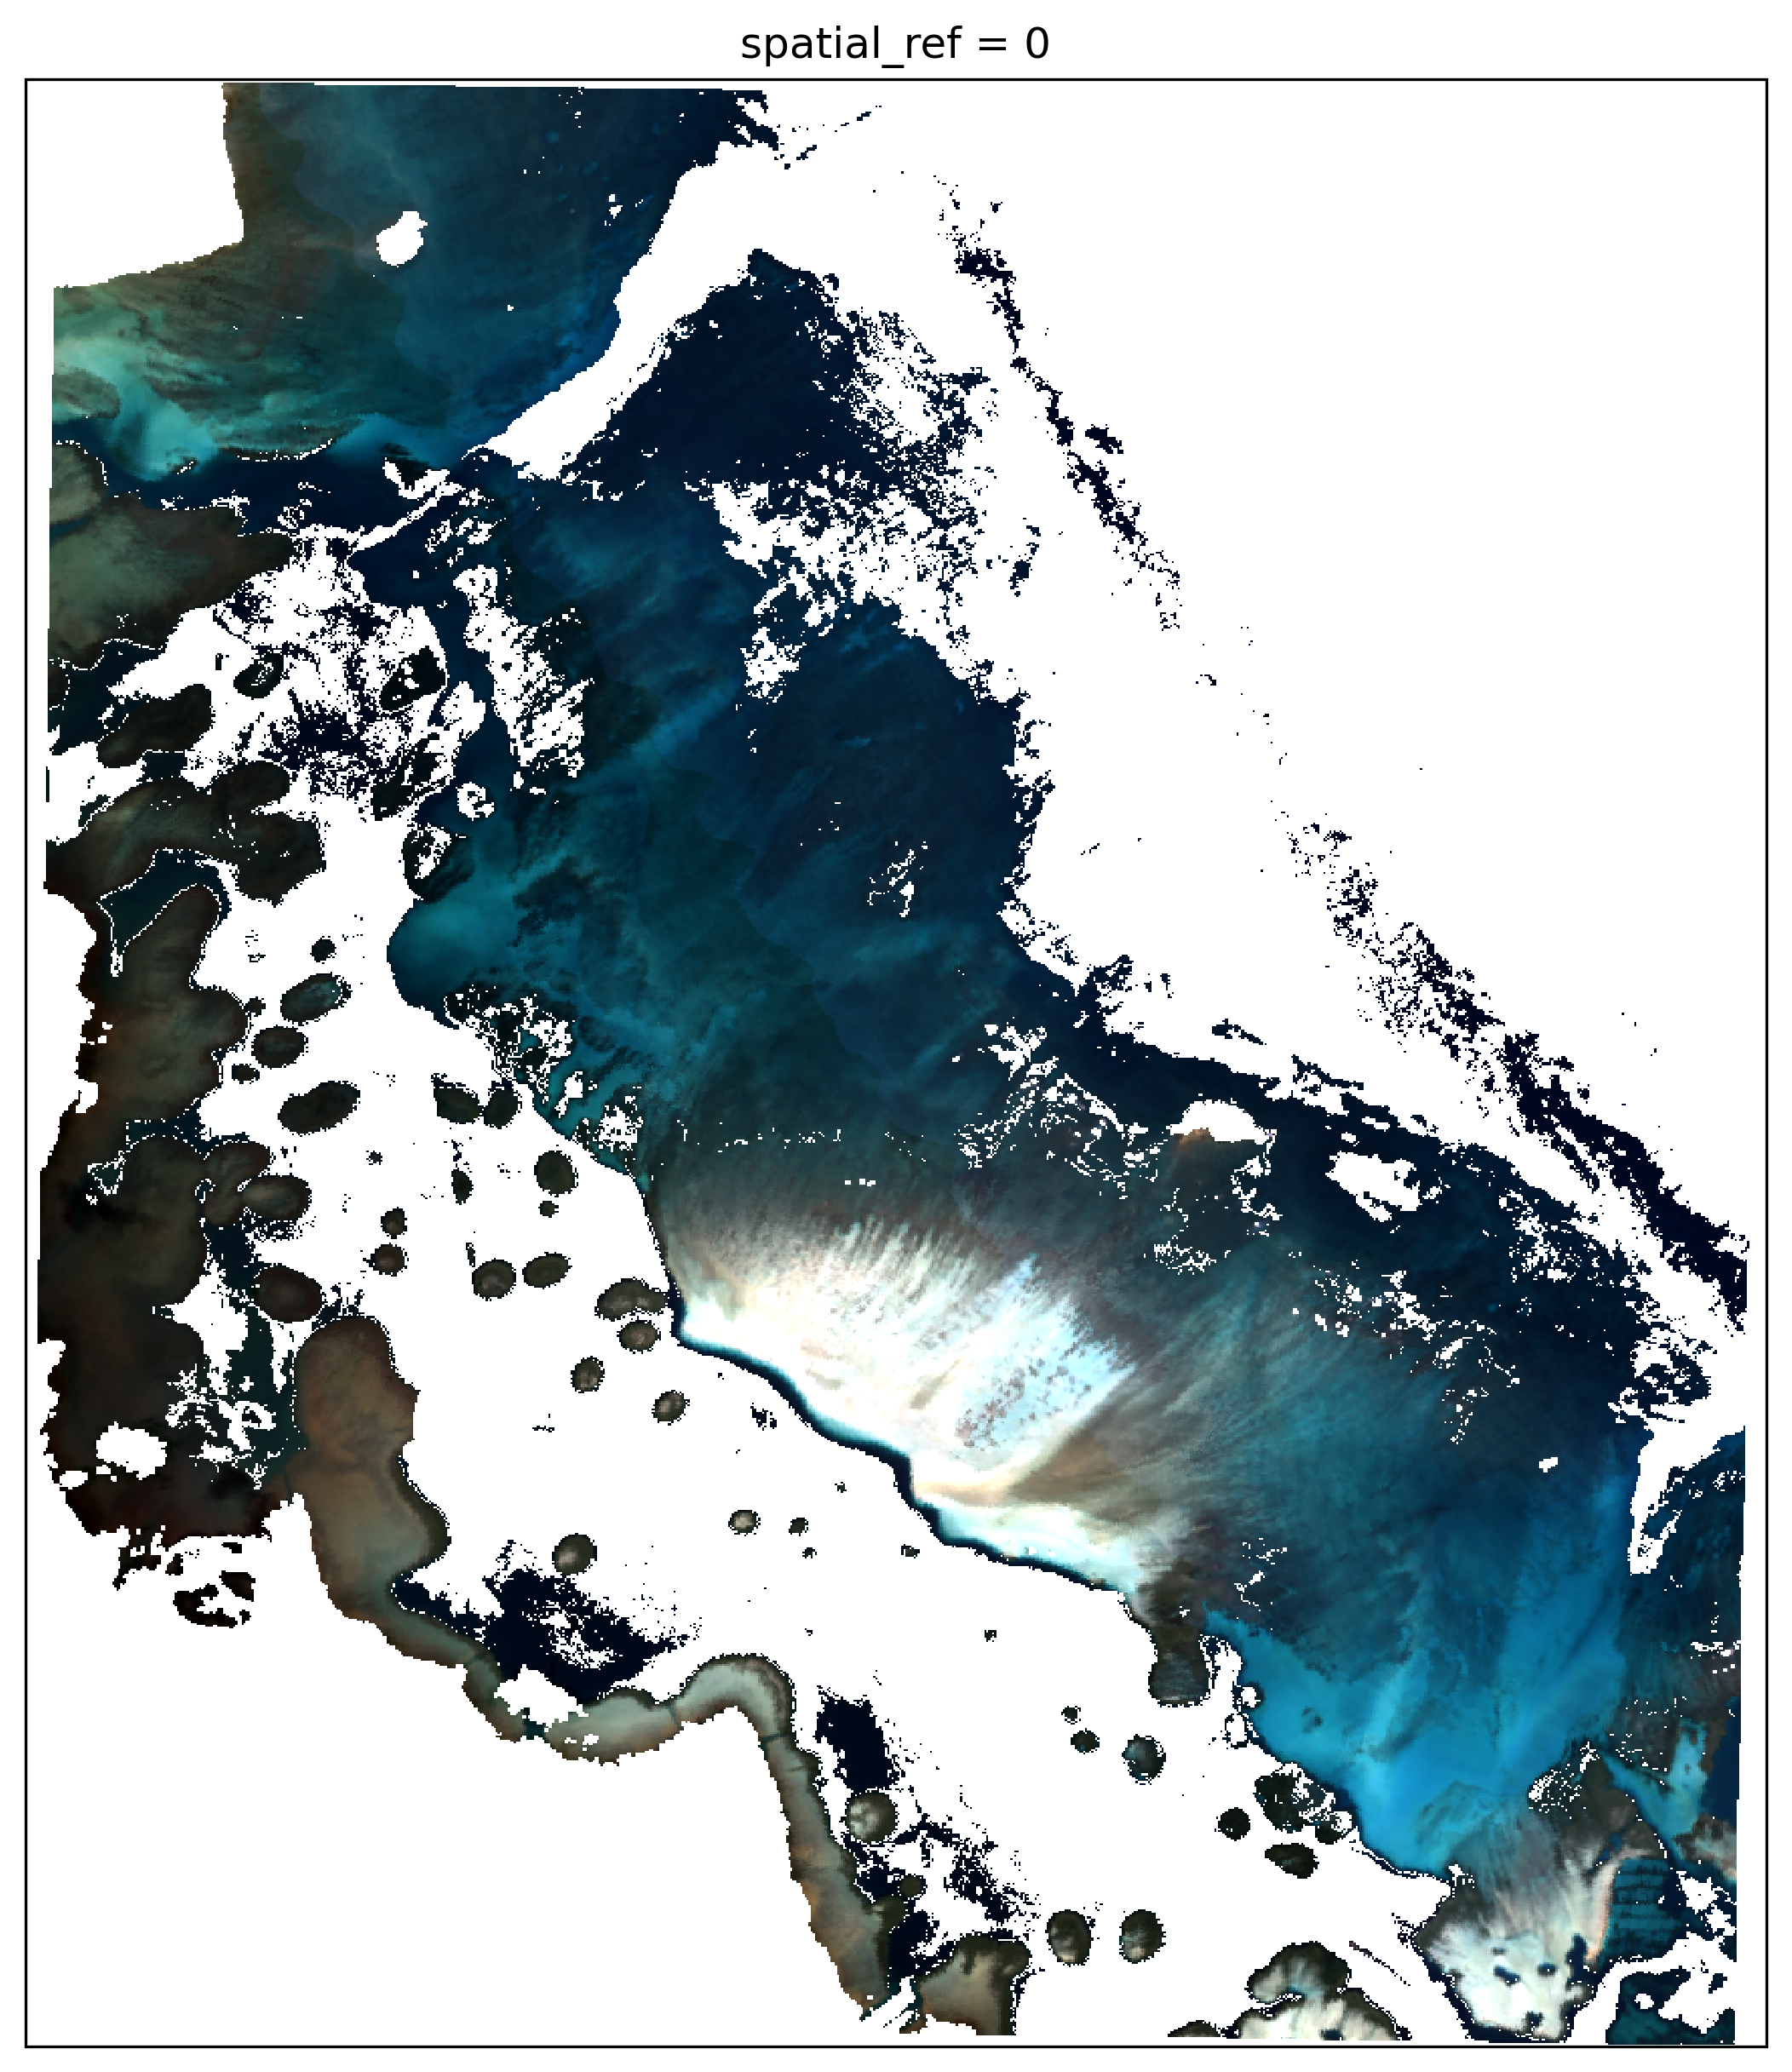

In [21]:
depth_masked_scene = rgb_xa.where(depth_rf_inferred["depth_pred"] <= 8, np.nan)
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
depth_masked_scene.plot.imshow(rgb="rgb", ax=ax, robust=True);

In [22]:
all_predictions_df = masked_endmember_rf_inferred.drop_vars(['spectra', 'band']).to_dataframe()

In [23]:
kbay_validation_data

X          Y Campaign       Locale  Station        TimeUTC  \
1151 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1152 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1153 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1154 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1155 -157.828916  21.492282   Hawaii  Kaneohe Bay      618  2/16/17 22:04   
...          ...        ...      ...          ...      ...            ...   
1559 -157.815017  21.508195   Hawaii  Kaneohe Bay      619  2/16/17 23:44   
1560 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1561 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1562 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1563 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   

          TimeLocal  Depth Metabolism Optics  ... sedLimest  sedMud  \
1151   2/15/17 8:45    5.5        NaN    NaN  ...         0       0   
1152   2/15/17 8:45    5.5        NaN    NaN  ...         0       0   
1153   2/15/17 8:45    5.5        NaN    NaN  ...         0       0   
1154   2/15/17 8:45    5.5        NaN    NaN  ...         0       0   
1155  2/16/17 11:04    4.9        NaN    NaN  ...         0       0   
...             ...    ...        ...    ...  ...       ...     ...   
1559  2/16/17 12:44    4.3        NaN    NaN  ...         0       0   
1560  2/16/17 13:10    5.2        NaN    NaN  ...         0       0   
1561  2/16/17 13:10    5.2        NaN    NaN  ...         0       0   
1562  2/16/17 13:10    5.2        NaN    NaN  ...         0       0   
1563  2/16/17 13:10    5.2        NaN    NaN  ...         0       0   

      sedRubble  sedSand  ROInumber                        Flightline  algae  \
1151          0        4        199  prm20170306t194614_corr_v1w3_img     56   
1152          0        4        199  prm20170306t194614_corr_v1w3_img     56   
1153          0        4        199  prm20170306t194614_corr_v1w3_img     56   
1154          0        4        199  prm20170306t194614_corr_v1w3_img     56   
1155          0        9        200  prm20170306t194614_corr_v1w3_img     34   
...         ...      ...        ...                               ...    ...   
1559          0        3        287  prm20170306t202626_corr_v1w3_img     80   
1560          0        2        288  prm20170306t202626_corr_v1w3_img     72   
1561          0        2        288  prm20170306t202626_corr_v1w3_img     72   
1562          0        2        288  prm20170306t202626_corr_v1w3_img     72   
1563          0        2        288  prm20170306t202626_corr_v1w3_img     72   

      coral  sand  Depth_label  
1151   39.0     4          5.5  
1152   39.0     4          5.5  
1153   39.0     4          5.5  
1154   39.0     4          5.5  
1155   45.0     9          4.9  
...     ...   ...          ...  
1559   17.0     3          4.3  
1560   26.0     2          5.2  
1561   26.0     2          5.2  
1562   26.0     2          5.2  
1563   26.0     2          5.2  

[395 rows x 38 columns]

In [24]:
import numpy as np

# Verify latitude matching
lat_diff = np.abs(masked_endmember_rf_inferred.lat.values - kbay_validation_data.Y.values[:, np.newaxis])
kbay_validation_data["pixel_y"] = np.argmin(lat_diff, axis=1)

# Verify longitude matching
lon_diff = np.abs(masked_endmember_rf_inferred.lon.values - kbay_validation_data.X.values[:, np.newaxis])
kbay_validation_data["pixel_x"] = np.argmin(lon_diff, axis=1)

np.argmin(lon_diff, axis=1).shape

(395,)

In [25]:
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x'],
      dtype='object')

In [26]:
algae_preds = []
coral_preds = []
sand_preds = []

for i in range(kbay_validation_data.shape[0]):
    point = endmember_rf_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest")
    algae_preds.append(point.algae_pred.values)
    coral_preds.append(point.coral_pred.values)
    sand_preds.append(point.sand_pred.values)

# plot algae_preds, coral_preds, sand_preds

In [27]:
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x'],
      dtype='object')

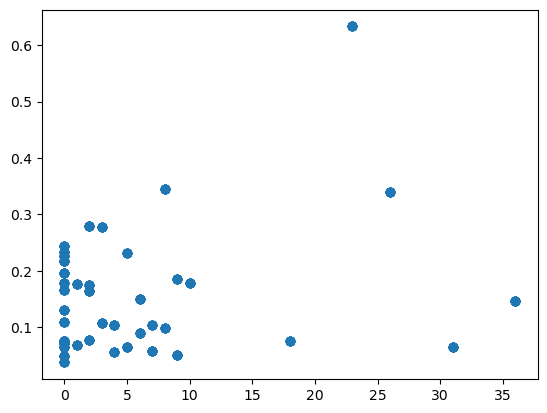

In [28]:
# plt.scatter(kbay_validation_data.algae, algae_preds)
# plt.scatter(kbay_validation_data.coral, coral_preds)
plt.scatter(kbay_validation_data.sand, sand_preds)

21.480649 -157.825682
3.4
inferred depth: 7.323076923076925
labels 0.34 0.35 0.31
predictions 0.5879565217391302 0.37219413549039443 0.06404347826086944


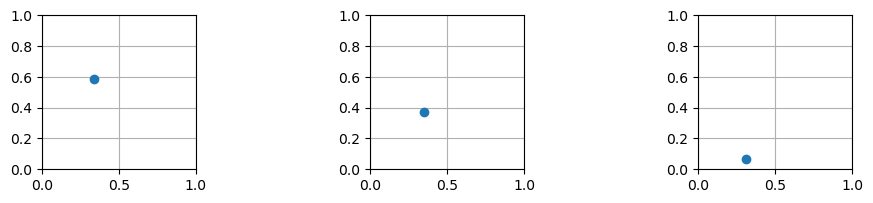

In [29]:
i = 40
# for i in range(len(kbay_validation_data)):
print(kbay_validation_data.Y.iloc[i], kbay_validation_data.X.iloc[i])
algae_label = kbay_validation_data.algae.iloc[i]/100
coral_label = kbay_validation_data.coral.iloc[i]/100
sand_label = kbay_validation_data.sand.iloc[i]/100
print(kbay_validation_data.Depth.iloc[i])
print("inferred depth:", depth_rf_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest").depth_pred.values)
print("labels", algae_label, coral_label, sand_label)

point = endmember_rf_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest")
algae_pred = point.algae_pred.values
coral_pred = point.coral_pred.values
sand_pred = point.sand_pred.values
print("predictions", algae_pred, coral_pred, sand_pred)

fig, ax = plt.subplots(1,3, figsize=(12, 2))

ax[0].plot(algae_label, algae_pred, 'o')
ax[1].plot(coral_label, coral_pred, 'o')
ax[2].plot(sand_label, sand_pred, 'o')
[a.set_xlim(0, 1) for a in ax];
[a.set_ylim(0, 1) for a in ax];
[a.set_aspect('equal') for a in ax];
[a.grid() for a in ax];

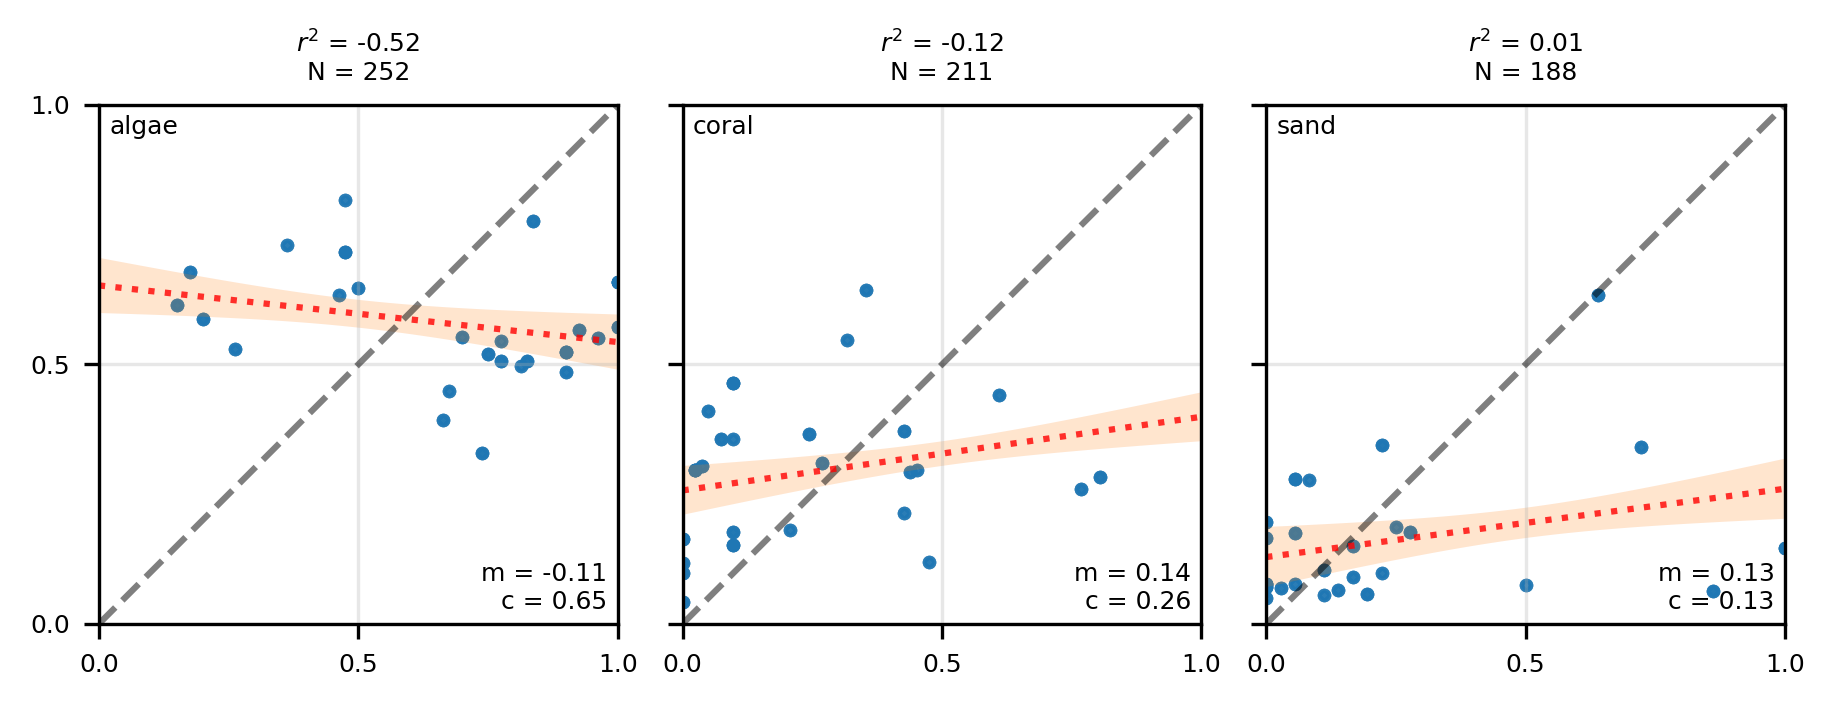

In [30]:
# find the closest pixel to each site in kbay_validation_data
kbay_validation_data["lat"] = kbay_validation_data.Y
kbay_validation_data["lon"] = kbay_validation_data.X
kbay_validation_data["pixel_x"] = np.argmin(np.abs(masked_endmember_rf_inferred.lon.values - kbay_validation_data.X.values[:, np.newaxis]), axis=1)
kbay_validation_data["pixel_y"] = np.argmin(np.abs(masked_endmember_rf_inferred.lat.values - kbay_validation_data.Y.values[:, np.newaxis]), axis=1)
# determine index of prediction from closest pixel
kbay_validation_data["pixel_index"] = kbay_validation_data.pixel_y * masked_endmember_rf_inferred.lon.shape[0] + kbay_validation_data.pixel_x
kbay_validation_data["algae_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,0]
kbay_validation_data["coral_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,1]
kbay_validation_data["sand_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,2]
# add boolean column for train or test data
kbay_validation_data["train-test"] = kbay_validation_data.index.isin(kbay_train_inds)
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x', 'lat', 'lon',
       'pixel_index', 'algae_pred', 'coral_pred', 'sand_pred', 'train-test'],
      dtype='object')

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


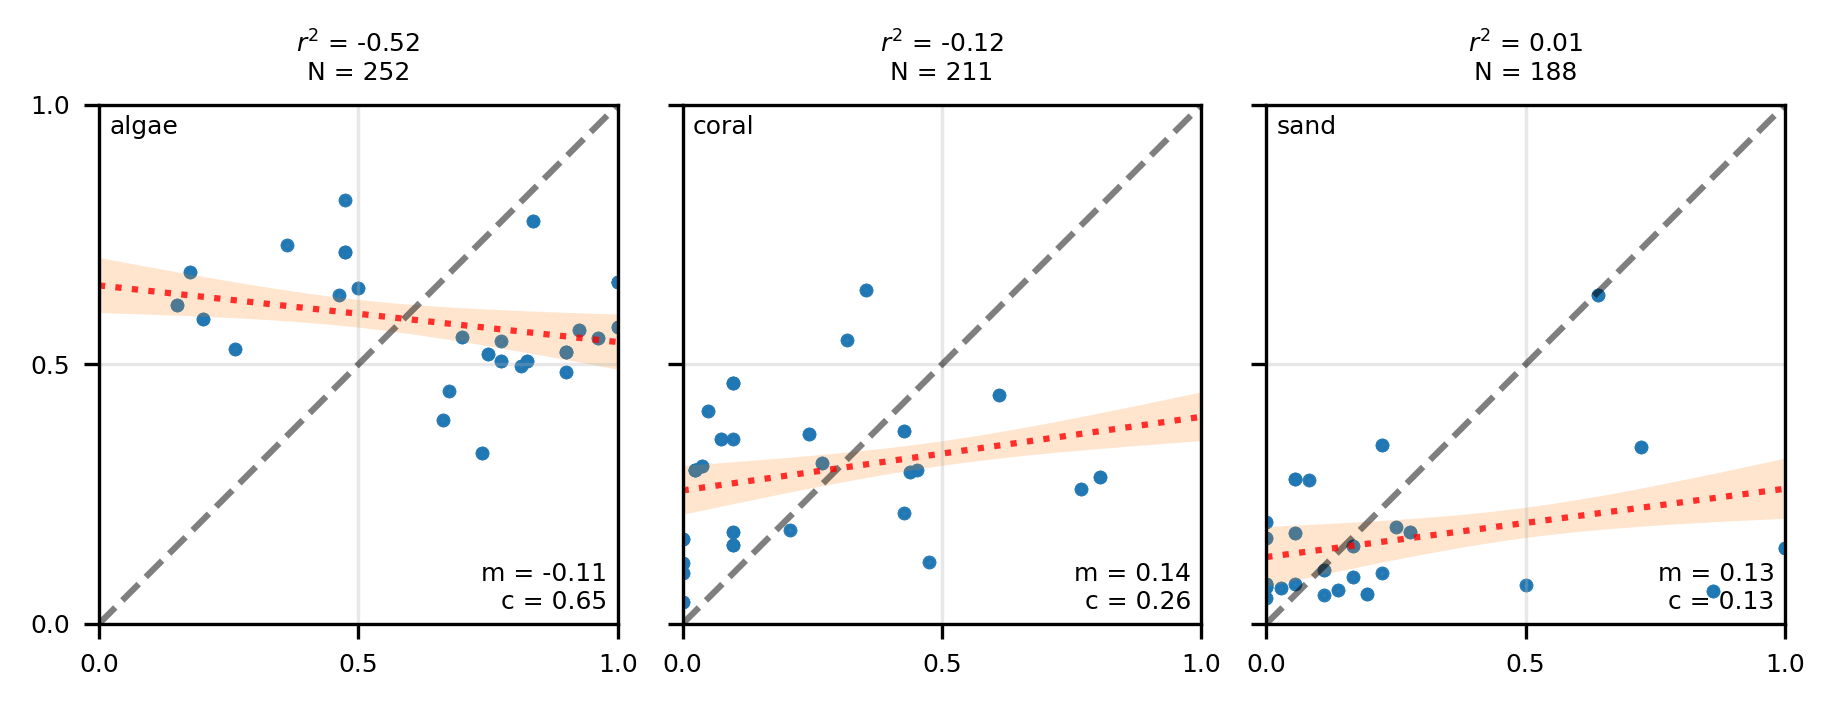

In [31]:
pred_data = kbay_validation_data[["algae_pred", "coral_pred", "sand_pred"]].values
pred_nan_inds = np.isnan(pred_data).any(axis=1)
pred_data = pred_data[~pred_nan_inds]

true_data = kbay_validation_data[["algae", "coral", "sand"]].values[~pred_nan_inds]
# scale true data 
scaler = MinMaxScaler()
scaler = scaler.fit(kbay_validation_data[["algae", "coral", "sand"]].loc[kbay_train_inds])  # scale on train data
test_data = pd.DataFrame(scaler.transform(true_data), columns=["algae", "coral", "sand"])

plotting.plot_regression_results(test_data, pred_data, benthic_labels,
                                #  metadata=kbay_validation_data.loc[pred_nan_inds], color_by="Depth"
                                 )

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


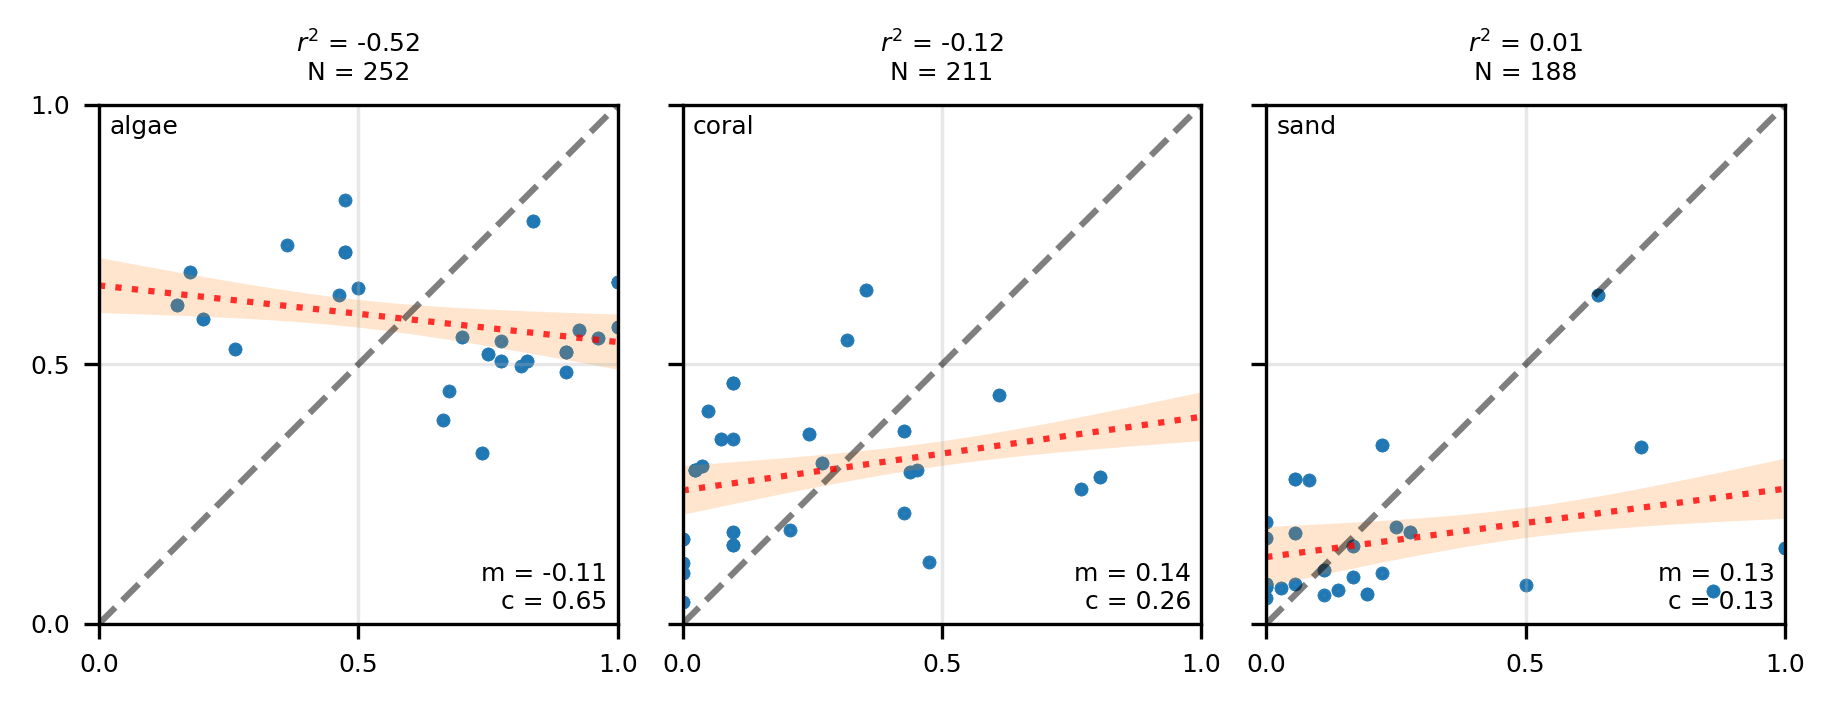

In [32]:

# scaler = scaler.fit(kbay_validation_data[["algae", "coral", "sand"]].loc[kbay_indices.intersection(kbay_validation_data.index)])  # scale on train data
# scale data by train scaler
# test_data = pd.DataFrame(scaler.transform(kbay_validation_data[["algae", "coral", "sand"]]), index=kbay_validation_data.index, columns=["coral", "algae", "sand"])
test_data = pd.DataFrame(scaler.transform(true_data), columns=["algae", "coral", "sand"])
# pred_data = kbay_validation_data[["algae_pred", "coral_pred", "sand_pred"]].values
labels = pd.DataFrame(kbay_validation_data[["algae", "coral", "sand"]], index=kbay_validation_data.index, columns=["algae", "coral", "sand"])


plotting.plot_regression_results(test_data, pred_data, labels,
                                #  metadata=kbay_validation_data.loc[pred_nan_inds], color_by="Depth"
                                 )

In [33]:
# depth predictions

scaler = MinMaxScaler()
scaler = scaler.fit(pd.DataFrame(kbay_validation_data["Depth"].loc[kbay_train_inds]))  # scale on train data
# scale data by train scaler
test_data = pd.DataFrame(scaler.transform(pd.DataFrame(kbay_validation_data["Depth"])), index=kbay_validation_data.index, columns=["Depth"])
pred_data = kbay_validation_data["Depth"].values

In [34]:
test_data

Depth
1151  0.370690
1152  0.370690
1153  0.370690
1154  0.370690
1155  0.318966
...        ...
1559  0.267241
1560  0.344828
1561  0.344828
1562  0.344828
1563  0.344828

[395 rows x 1 columns]

In [35]:
# scale ["coral", "algae", "sand"] columns in kbay_validation_data
# kbay_validation_data[["coral", "algae", "sand"]] = scaler.transform(kbay_validation_data[["coral", "algae", "sand"]])

train_results = kbay_validation_data[kbay_validation_data["train-test"] == True]
test_results = kbay_validation_data[kbay_validation_data["train-test"] == False]
train_results_true = train_results[["coral", "algae", "sand"]]
train_results_pred = train_results[["coral_pred", "algae_pred", "sand_pred"]]
test_results_true = test_results[["coral", "algae", "sand"]]
test_results_pred = test_results[["coral_pred", "algae_pred", "sand_pred"]]

In [36]:
train

NameError: name 'train' is not defined

(0.0, 1.0)

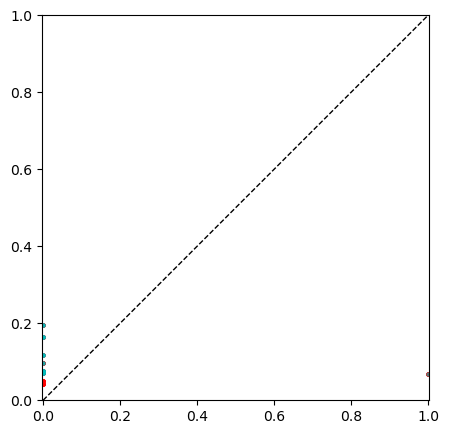

In [60]:
plt.figure(figsize=(5, 5))
plt.scatter(train_results_true, train_results_pred, color="r", label="Train Data", alpha=0.5, s=5)
plt.scatter(test_results_true, test_results_pred, color="c", label="Test Data", alpha=0.5, s=5)
plt.plot([0, 1], [0, 1], color="k", lw=1, ls="--")
plt.axis("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)

# r2_score(test_results_true, test_results_pred)

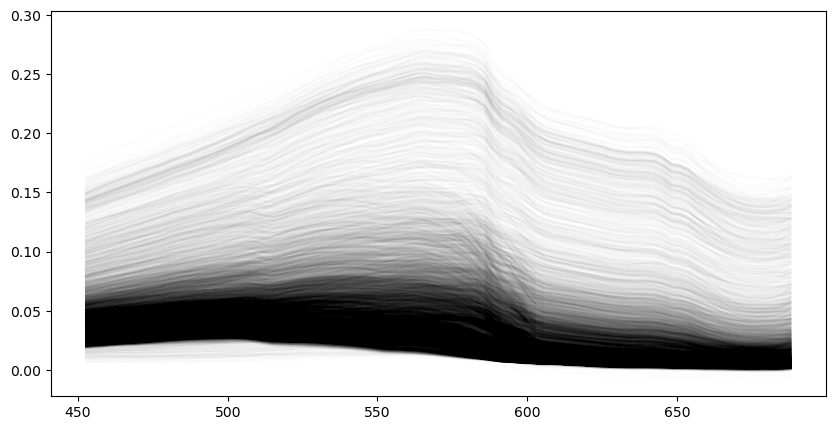

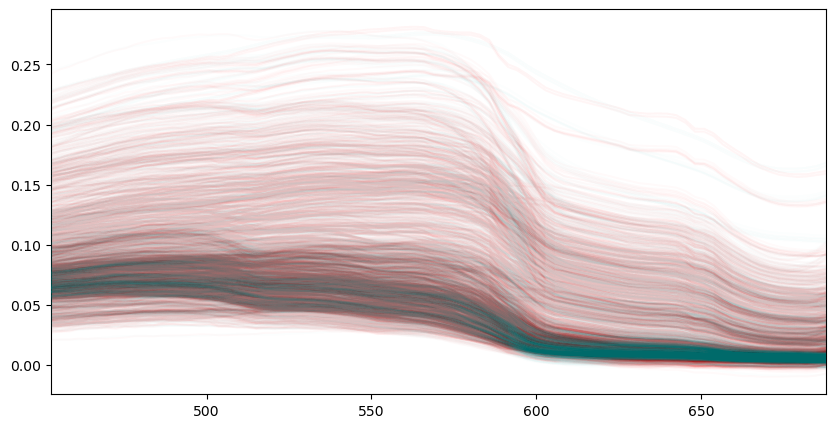

In [247]:
# compare spectra
prism_spectra = spectrum_utils.preprocess_prism_spectra(spectrum_utils.load_spectra())
fit_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/results/fits/fit_results_1.csv"
fits = pd.read_csv(fit_fp, header=[0,1])
fits = fits.fitted_spectra
fits.columns = fits.columns.astype(float)

plt.figure(figsize=(10, 5))
plt.plot(no_nan_hs_vals[::100].T, c="k", alpha=0.01);
plt.figure(figsize=(10, 5))
plt.plot(prism_spectra.T, c="r", alpha=0.02);
plt.plot(fits.T, c="c", alpha=0.01, zorder=10);
plt.xlim(prism_spectra.columns.min(), prism_spectra.columns.max());

In [239]:
N = -1
spectra_source1 = no_nan_hs_vals.iloc[:N,:]
spectra_source2 = prism_spectra.iloc[:N,:]
spectra_source3 = fits.iloc[:N,:]
spectra_source2.shape[1]

84

In [240]:
# statistically compare two batches of spectra

p_values = np.zeros(spectra_source1.shape[1])
for i in range(spectra_source1.shape[1]):
    stat, p_val = ks_2samp(spectra_source3.iloc[:, i], spectra_source2.iloc[:, i])
    p_values[i] = p_val
    
p_values

array([9.99999994e-01, 1.00000000e+00, 1.00000000e+00, 9.99950146e-01,
       1.00000000e+00, 9.99999926e-01, 9.10018309e-01, 8.91655558e-01,
       9.97034939e-01, 9.99999994e-01, 9.65244158e-01, 9.74370125e-01,
       9.26626950e-01, 9.99999411e-01, 1.00000000e+00, 9.99996662e-01,
       9.99950146e-01, 9.99999994e-01, 9.99197036e-01, 9.99996662e-01,
       9.87493385e-01, 6.99817690e-01, 8.50178092e-01, 9.87493385e-01,
       6.18677374e-01, 4.63108513e-01, 8.27374875e-01, 8.71659946e-01,
       9.41392815e-01, 9.99197036e-01, 9.99996662e-01, 9.99999994e-01,
       9.99999411e-01, 9.99950146e-01, 9.97034939e-01, 7.78516183e-01,
       9.41392815e-01, 9.99999994e-01, 1.00000000e+00, 9.94919931e-01,
       9.99855490e-01, 9.98389890e-01, 8.50178092e-01, 9.94919931e-01,
       9.99638092e-01, 9.87493385e-01, 9.81739160e-01, 8.03426817e-01,
       1.83655151e-01, 2.57209681e-01, 3.93197202e-01, 2.43370320e-03,
       8.12867044e-06, 2.22903770e-07, 7.09075388e-09, 2.91456585e-13,
      

In [241]:
# pca both distributions

pca1 = PCA(n_components=1)
pca1.fit(spectra_source3)
pca_source1 = pca1.transform(spectra_source1)
pca2 = PCA(n_components=1)
pca2.fit(spectra_source2)
pca_source2 = pca2.transform(spectra_source2)

# statistically compare pca components
stat, p_val = ks_2samp(pca_source1, pca_source2)
print(stat, p_val)

[0.48761587] [0.]


In [242]:
ks_2samp(pca_source1, pca_source1)

KstestResult(statistic=array([0.]), pvalue=array([1.]), statistic_location=array([-0.66107043]), statistic_sign=array([1.]))

In [211]:

# Combine data from both sources and add a label
data = np.vstack([spectra_source1.values, spectra_source2.values])
labels = np.array([0]*spectra_source1.shape[0] + [1]*spectra_source2.shape[0])

# Perform MANOVA (multivariate analysis of variance)
manova = MANOVA(endog=data, exog=labels)
print(manova.mv_test())


                     Multivariate linear model
                                                                   
-------------------------------------------------------------------
           x0           Value   Num DF    Den DF    F Value  Pr > F
-------------------------------------------------------------------
          Wilks' lambda 0.7498 84.0000 698926.0000 2776.7695 0.0000
         Pillai's trace 0.2502 84.0000 698926.0000 2776.7695 0.0000
 Hotelling-Lawley trace 0.3337 84.0000 698926.0000 2776.7695 0.0000
    Roy's greatest root 0.3337 84.0000 698926.0000 2776.7695 0.0000



- Predict depth and compare with LIDAR
- Use depth as a parameter

# Depth


In [37]:
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
# mask depth
depth_trained_model = joblib.load(file_ops.MODELS_DIR_FP / "20241004-125736/best_rf_depth_no_kaneohe.pkl")
depth_rf_inferred = infer_on_spatial(depth_trained_model, scene_xa, ["depth"])

depth_trained_mlp_model = joblib.load(file_ops.MODELS_DIR_FP / "20241004-132443/best_mlp_depth_no_kaneohe.pkl")
depth_mlp_inferred = infer_on_spatial(depth_trained_mlp_model, scene_xa, ["depth"])

# scale depth values according to validation data
depth_rf_inferred["rf_depth_pred"] = depth_rf_inferred["depth_pred"] * np.max(validation_data.Depth)
depth_mlp_inferred["mlp_depth_pred"] = depth_mlp_inferred["depth_pred"] * np.max(validation_data.Depth)

# merge 
inferred_depth_ds = xa.merge([depth_rf_inferred["rf_depth_pred"], depth_mlp_inferred["mlp_depth_pred"]], compat="override")
# rio formatting
inferred_depth_ds.rio.write_crs(scene_xa.rio.crs, inplace=True)
inferred_depth_ds.rio.set_spatial_dims("lon", "lat", inplace=True)

<xarray.Dataset> Size: 14MB
Dimensions:         (lat: 1045, lon: 863)
Coordinates:
  * lat             (lat) float64 8kB 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon             (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8
    spatial_ref     int64 8B 0
Data variables:
    rf_depth_pred   (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan
    mlp_depth_pred  (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan

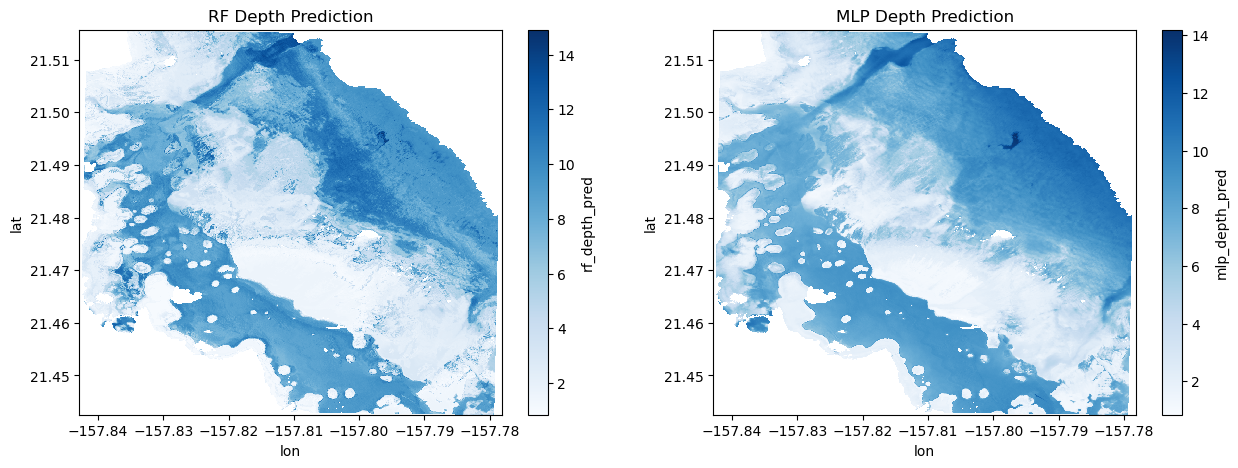

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
inferred_depth_ds["rf_depth_pred"].plot.imshow(ax=ax[0], cmap="Blues")
ax[0].set_title("RF Depth Prediction")
inferred_depth_ds["mlp_depth_pred"].plot.imshow(ax=ax[1], cmap="Blues")
ax[1].set_title("MLP Depth Prediction");

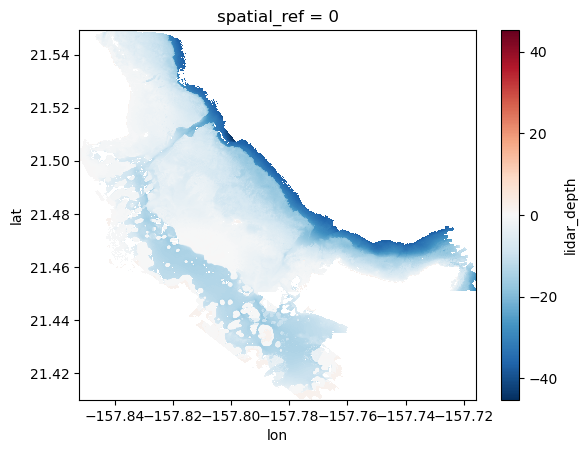

In [39]:
import numpy as np
import xarray as xa
from pyproj import Transformer

def process_grd_dataset(ds: xa.Dataset, src_crs: str = "EPSG:XXXXX", dst_crs: str = "EPSG:4326") -> xa.Dataset:
    x_range = ds.x_range.values
    y_range = ds.y_range.values
    spacing = ds.spacing.values
    
    x_coords = np.arange(min(x_range), max(x_range) + spacing[0], spacing[0])
    y_coords = np.arange(min(y_range), max(y_range) + spacing[1], spacing[1])[::-1]
    
    # reproject x, y coordinates to lat/lon (EPSG:4326)
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    lon_coords, lat_coords = np.meshgrid(x_coords, y_coords)
    lon_coords, lat_coords = transformer.transform(lon_coords, lat_coords)

    # reshape z data to match new (lat, lon) grid
    z_data = ds['z'].values.reshape(len(y_coords), len(x_coords))

    new_ds = xa.Dataset(
        {
            'lidar_depth': (['lat', 'lon'], z_data)
        },
        coords={
            'lon': (['lon'], lon_coords[0, :]),  # Longitude grid
            'lat': (['lat'], lat_coords[:, 0])   # Latitude grid
        },
        attrs=ds.attrs,  # Keep original attributes
    )
    new_ds.where(new_ds.apply(np.isfinite)).fillna(np.nan)
    # rioxarray formatting
    new_ds.rio.write_crs(dst_crs, inplace=True)
    new_ds.rio.set_spatial_dims("lon", "lat", inplace=True)
    # replace inf with nan
    return new_ds

def load_grd_to_xarray(grd_file: str) -> xa.Dataset:
    # Load the .grd file directly with xarray (assuming NetCDF format)
    ds = xa.open_dataset(grd_file)
    return ds

# Load the .grd file
grd_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/lidar/kaneohe_bathy_4m/kaneohe_MB_Lidar_4m.grd"
ds = load_grd_to_xarray(grd_fp)
    
# Process and reproject the dataset
lidar_xa = process_grd_dataset(ds, src_crs="EPSG:32604")
lidar_xa.lidar_depth.plot()

In [40]:
reprojected_lidar = lidar_xa.rio.reproject_match(inferred_depth_ds)
# combine inferred dataset and lidar new dataset
depth_merged = xa.merge([reprojected_lidar, inferred_depth_ds])
rf_prediction_vals = depth_merged["rf_depth_pred"].values.flatten()
mlp_prediction_vals = depth_merged["mlp_depth_pred"].values.flatten()

[(0.0, 20.0), (0.0, 20.0)]

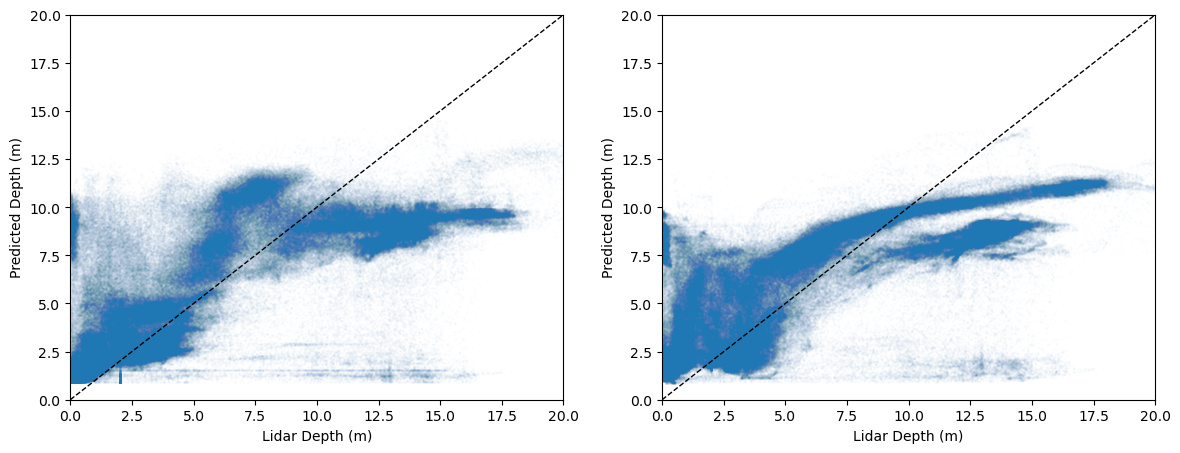

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# plot scatter of test and lidar
lidar_vals = np.abs(depth_merged["lidar_depth"].values.flatten())

axs[0].scatter(lidar_vals, rf_prediction_vals, s=1, alpha=0.01)
max_val = max(np.nanmax(rf_prediction_vals), np.nanmax(lidar_vals))
axs[1].scatter(lidar_vals, mlp_prediction_vals, s=1, alpha=0.01)
[ax.plot([0, 20], [0, 20], color="k", lw=1, ls="--") for ax in axs]
[ax.set_xlabel("Lidar Depth (m)") for ax in axs]
[ax.set_ylabel("Predicted Depth (m)") for ax in axs]
[ax.set_xlim(0, 20) for ax in axs]
[ax.set_ylim(0, 20) for ax in axs]

In [63]:
scene_xa.shape

(246, 1045, 863)

In [55]:
all_spectra = ml_utils.spectral_xa_to_processed_spectral_df(scene_xa)
all_spectra_scaled = ml_utils.process_df_for_inference(all_spectra)

In [59]:
inferred_depth_ds

<xarray.Dataset> Size: 14MB
Dimensions:         (lat: 1045, lon: 863)
Coordinates:
  * lat             (lat) float64 8kB 21.44 21.44 21.44 ... 21.52 21.52 21.52
  * lon             (lon) float64 7kB -157.8 -157.8 -157.8 ... -157.8 -157.8
    spatial_ref     int64 8B 0
Data variables:
    rf_depth_pred   (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan
    mlp_depth_pred  (lat, lon) float64 7MB nan nan nan nan ... nan nan nan nan

In [60]:
all_depths = ml_utils.spectral_xa_to_processed_spectral_df(inferred_depth_ds)
all_depths_scaled = ml_utils.process_df_for_inference(all_depths)

AttributeError: 'function' object has no attribute 'reshape'

In [56]:
all_spectra_scaled

452.642761  455.475067  458.307404  461.139801  463.972229  \
1631      0.293712    0.292423    0.286938    0.288554    0.289087   
1632      0.293454    0.293501    0.287528    0.289567    0.289730   
1633      0.294826    0.294600    0.291568    0.290123    0.291257   
1634      0.295391    0.295033    0.292956    0.291050    0.290335   
1635      0.296178    0.295042    0.291142    0.291343    0.290872   
...            ...         ...         ...         ...         ...   
899384    0.405624    0.408780    0.406526    0.407995    0.410514   
899385    0.406756    0.408582    0.405199    0.409050    0.411353   
899386    0.413511    0.415378    0.414724    0.417380    0.417757   
899387    0.417297    0.417640    0.420367    0.420824    0.420854   
899388    0.421615    0.421689    0.422261    0.422694    0.424278   

        466.804749  469.637299  472.469940  475.302612  478.135345  ...  \
1631      0.288037    0.286901    0.285031    0.282396    0.284202  ...   
1632      0.289013    0.286878    0.283391    0.282872    0.284306  ...   
1633      0.290285    0.288897    0.285787    0.282884    0.286232  ...   
1634      0.291462    0.290287    0.286835    0.284747    0.286616  ...   
1635      0.290658    0.289405    0.288129    0.284582    0.286780  ...   
...            ...         ...         ...         ...         ...  ...   
899384    0.410137    0.410944    0.411524    0.410254    0.411125  ...   
899385    0.411382    0.410694    0.409922    0.410477    0.411308  ...   
899386    0.419308    0.420402    0.419314    0.419205    0.420748  ...   
899387    0.423498    0.425348    0.425158    0.423868    0.425804  ...   
899388    0.426270    0.426555    0.428821    0.427082    0.428577  ...   

        662.383484  665.219910  668.056458  670.893005  673.729614  \
1631      0.120232    0.124601    0.125924    0.127681    0.128554   
1632      0.121197    0.125506    0.126011    0.127695    0.128895   
1633      0.124892    0.127759    0.129587    0.130576    0.131826   
1634      0.124758    0.127510    0.130186    0.130921    0.132795   
1635      0.124196    0.127627    0.129291    0.130691    0.132710   
...            ...         ...         ...         ...         ...   
899384    0.246377    0.243021    0.239755    0.239848    0.238294   
899385    0.244477    0.240348    0.237086    0.238329    0.235454   
899386    0.250552    0.248425    0.244377    0.245103    0.243492   
899387    0.253007    0.251471    0.248490    0.249029    0.246657   
899388    0.248532    0.246871    0.244695    0.246216    0.242500   

        676.566284  679.403015  682.239807  685.076599  687.913513  
1631      0.127280    0.126365    0.126513    0.126232    0.119434  
1632      0.127624    0.127694    0.127243    0.126674    0.119664  
1633      0.131349    0.131401    0.129684    0.129295    0.125030  
1634      0.132204    0.130922    0.131855    0.129616    0.125824  
1635      0.131224    0.130606    0.132072    0.129851    0.124623  
...            ...         ...         ...         ...         ...  
899384    0.237478    0.235440    0.232203    0.231995    0.225058  
899385    0.234677    0.233156    0.229042    0.229388    0.222172  
899386    0.241217    0.239778    0.237587    0.236863    0.229380  
899387    0.243278    0.242315    0.240924    0.239850    0.234538  
899388    0.240562    0.238158    0.236325    0.234534    0.229374  

[686658 rows x 84 columns]

In [43]:
# fit depth using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# remove nans
lidar_vals = lidar_vals[~np.isnan(prediction_vals)]
prediction_vals = prediction_vals[~np.isnan(prediction_vals)]

lr = LinearRegression()
lr.fit(lidar_vals.reshape(-1, 1), prediction_vals)
r2_score(lidar_vals, prediction_vals)


NameError: name 'prediction_vals' is not defined